<a href="https://colab.research.google.com/github/rnop/nmr_tournament/blob/main/introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction to the Numerai Tournament (**UPDATED FOR THE NEW 1K+ FEATURE DATASET**)
Numerai is a hedge fund that trades the global markets based on models created by data scientists all over the world. Numerai is unique in that it provides free high-quality financial datasets that are worth millions of dollars to any user wanting to participate in their tournament. Users are able to build their own models on this anonymized and obfuscated dataset, submit their predictions, and follow their investment performance on the live stock market. If users are confident about their models, they are able to stake on them with real money using Numerai's cryptocurrency, Numeraire (NMR).

### About this Notebook
The purpose of this notebook is to provide an introduction on how to approach the main Numerai tournament using Google Colab Pro. Pro version is needed for the extra VRAM!

Alot of the code is taken from example scripts from Numerai's official GitHub here: https://github.com/numerai/example-scripts

What's included:
* how to read in the new Numerai data via API
* train a lightgbm model
* calculating predictions from the current round

### Disclaimer
**This model is not guaranteed to make you money.** I am currently not staking this particular model in the tournament. This notebook only serves to provide you an introduction to the tournament and to give some of my personal input on how to tackle this data science problem. 

In [1]:
# Install Numerai API
! pip install --upgrade numerapi

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from numerapi import NumerAPI

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Instantiate Numerai API
napi = NumerAPI()
current_round = napi.get_current_round(tournament=8) # tournament=8 is the main tournament
print("Current Round:", current_round)

Current Round: 282


### Read in Training Data
Multiple types of files:
* CSV - standard csv file but has the highest VRAM and disk space usage
* parquet - uses less VRAM and disk space than CSV file
* int8.parquet (**highly recommended**)- converts data types to int8 (eg. 1.0 -> 4) which uses the least amount of VRAM and disk space

In [4]:
# Read in training data into pandas

csv_url = 'numerai_training_data.csv'
parquet_url = 'numerai_training_data.parquet'
int8_parquet_url = 'numerai_training_data_int8.parquet'

# Training data (int8 parquet file used)
napi.download_dataset('numerai_training_data_int8.parquet', 'numerai_training_data_int8.parquet') # Download via Numerai API
train_df = pd.read_parquet('numerai_training_data_int8.parquet') # Load into pandas DataFrame

print("Training Shape:", train_df.shape)
train_df.head()

2021-09-21 18:19:41,965 INFO numerapi.utils: starting download
numerai_training_data_int8.parquet: 1.01GB [00:47, 21.1MB/s]                            


Training Shape: (2412105, 1073)


,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,...,feature_oscillating_elaborated_mandatory,feature_contradictory_museful_somatotropin,feature_direst_interrupted_paloma,feature_congenerical_anodal_chelation,feature_pronominal_rampant_megaspore,feature_dropsical_suctorial_mnemosyne,feature_corrugated_dotiest_committeewoman,feature_architectonic_godlier_southland,feature_fishiest_simulatory_roadholding,feature_unpruned_pedagoguish_inkblot,feature_forworn_hask_haet,feature_drawable_exhortative_dispersant,feature_metabolic_minded_armorist,feature_investigatory_inerasable_circumvallation,feature_centroclinal_incentive_lancelet,feature_unemotional_quietistic_chirper,feature_behaviorist_microbiological_farina,feature_lofty_acceptable_challenge,feature_coactive_prefatorial_lucy,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,target_alan_60,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,3,0,2,4,0,4,0,4,0,4,1,2,1,1,1,0,0,4,4,0,0,3,4,1,0,1,1,3,4,0,...,4,4,3,2,3,3,0,0,0,0,4,3,4,3,2,4,4,1,0,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.50,0.25,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000
n003bee128c2fcfc,0001,train,2,4,1,3,0,3,2,3,2,2,2,1,4,0,3,0,3,1,1,1,1,3,1,2,3,2,3,3,3,4,3,3,3,3,3,4,3,1,...,3,1,0,0,2,2,1,1,2,2,0,1,0,1,0,1,2,4,3,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.75,0.50,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,4,2,0,0,3,2,2,2,1,3,2,0,0,0,1,1,4,2,3,4,4,1,0,4,1,0,1,1,0,3,...,1,3,1,2,3,2,2,2,2,2,2,3,4,2,1,2,3,3,4,0.50,0.50,0.25,0.50,0.25,0.25,0.25,0.50,0.25,0.25,0.50,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333
n00691bec80d3e02,0001,train,4,2,2,3,0,4,1,4,1,3,1,4,0,2,1,2,0,2,0,1,3,4,0,0,0,4,2,0,0,4,3,4,1,1,1,2,0,0,...,0,3,0,3,1,4,0,0,0,0,1,2,2,2,1,0,1,0,2,0.75,0.75,0.50,0.50,0.50,0.50,0.75,0.75,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,4,3,4,4,0,0,4,2,3,0,1,3,2,0,3,0,3,1,2,1,0,0,1,1,1,4,4,3,1,4,4,0,0,0,0,1,3,1,...,4,4,0,3,1,0,2,1,2,1,4,0,1,4,1,4,4,2,1,0.75,0.75,0.50,0.50,0.50,0.75,0.75,0.50,0.50,0.75,0.50,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000


### Features
* There are 1050 features in the new dataset
* Some features are highly correlated (and uncorrelated) with other features
  * This correlation changes over time across different eras!
* It is up to you to decide whether you want to reduce the number of features your model will use
* This notebook will not go into great detail in feature exploration


In [5]:
features = [c for c in train_df if c.startswith("feature")]
print(features[:5]) # Print first 5 features
print("Number of features:", len(features))

['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer', 'feature_pert_performative_hormuz', 'feature_hillier_unpitied_theobromine', 'feature_perigean_bewitching_thruster']
Number of features: 1050


### Targets
* Numerai has given us 10 different targets (2 versions of each using a 20-day and 60-day window)
* The main target we are scored on is **'target'** and **'target_nomi_20'** which are identical
* It might be useful to use other targets to boost prediction scores for the main target

In [6]:
target = "target" # Main target you want to predict for the tournament
targets = [c for c in train_df if c.startswith("target")]
print(targets[:7]) # Print first 7 targets
print("Number of targets:", len(targets))

['target', 'target_nomi_20', 'target_nomi_60', 'target_jerome_20', 'target_jerome_60', 'target_janet_20', 'target_janet_60']
Number of targets: 21


### Pre-Processing
* Convert 'era' to int type
* Remove overlapping columns
  * The data set now contains overlapping eras
    * Eras are now defined weekly 
    * You can think of Eras 1-4 as the same month
    * BUT, since targets are 4 weeks out (20 days), if you train on Era 1 and validate on Eras 2, 3, or 4, it will lead to problems with autocorrelation, data leakage which lead to overfitting
    * Solution is to remove overlapping eras by sampling every 4th era

In [7]:
print("Number of training eras:", len(set(train_df['era'])))

Number of training eras: 574


In [8]:
# Useful to convert 'era' column into ints 
train_df["erano"] = train_df.era.astype(int)
eras = train_df.erano

# Make sure our data doesn't use overlapped data
nonoverlap_eras = np.arange(1, 575, 4) # subsample every 4th era
train_df = train_df[train_df['erano'].isin(nonoverlap_eras)]

### Train LightGBM and Save/Load Model

In [9]:
import lightgbm

if 'lgb_example.txt' is True: # Check if model is saved in current directory
  print("Loading LightGBM model...")
  lgb = lightgbm.Booster(model_file='lgb_example.txt')

else:
  print("Training LightGBM model...")
  # Hyperparameters are given from Numerai example script
  params = {"n_estimators": 2000,
            "learning_rate": 0.01,
            "max_depth": 5,
            "num_leaves": 2 ** 5,
            "colsample_bytree": 0.1}

  lgb = lightgbm.LGBMRegressor(**params) # Instantiate model
  lgb.fit(train_df[features], train_df[target]) # Train model
  lgb.booster_.save_model('lgb_example.txt') # Save model

Training LightGBM model...


### Evaluation Metrics
* Correlation Score
* Mean Sharpe

In [10]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

def score(df):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df['target'],
        df['prediction'].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print()
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print()
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

count    604111.000
mean          0.500
std           0.015
min           0.352
25%           0.491
50%           0.500
75%           0.509
max           0.594
Name: prediction, dtype: float64



2021-09-21 18:25:36,600 INFO numexpr.utils: NumExpr defaulting to 4 threads.


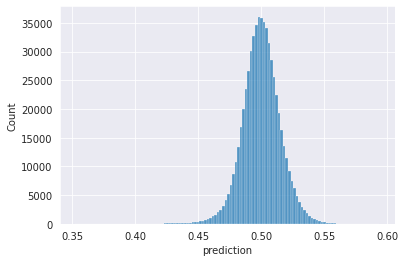


Training Correlation Score: 0.2062638574352648

Mean Correlation: 0.1964
Median Correlation: 0.1971
Standard Deviation: 0.0278

Mean Pseudo-Sharpe: 7.0682
Median Pseudo-Sharpe: 7.0939

Hit Rate (% positive eras): 100.00%


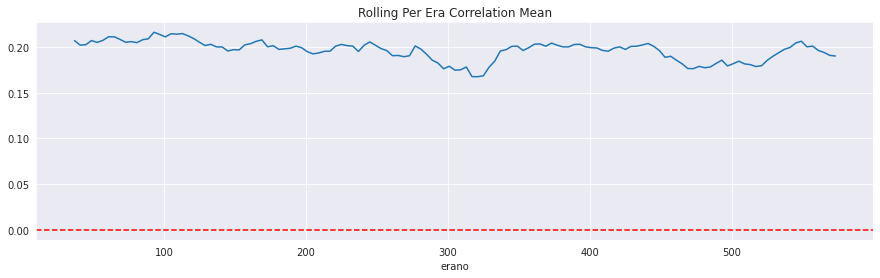

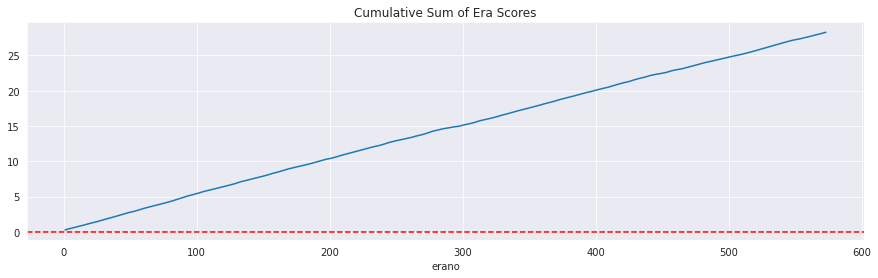

In [11]:
# Evaluate Training Data
train_df['prediction'] = lgb.predict(train_df[features])

# Check distribution of predictions
print(train_df['prediction'].describe().round(3))
print()
sns.histplot(train_df['prediction'], bins=120)
plt.show()
print()

print("Training Correlation Score:", correlation_score(train_df['target'], train_df['prediction']))
print()
mean_train_era_scores = train_df.groupby(train_df['erano']).apply(score)
run_analytics(mean_train_era_scores)

* Oof, the model is clearly overfitting. 

In [12]:
# Load Validation data
napi.download_dataset('numerai_validation_data_int8.parquet', 'numerai_validation_data_int8.parquet')
valid_df = pd.read_parquet('numerai_validation_data_int8.parquet')
valid_df["erano"] = valid_df.era.astype(int)

2021-09-21 18:25:39,660 INFO numerapi.utils: starting download
numerai_validation_data_int8.parquet: 228MB [00:12, 17.6MB/s]                           


count    539658.000
mean          0.500
std           0.014
min           0.412
25%           0.491
50%           0.500
75%           0.510
max           0.578
Name: prediction, dtype: float64



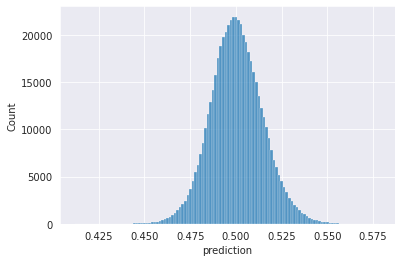


Validation Correlation Score: 0.025223128950311494

Mean Correlation: 0.0233
Median Correlation: 0.0220
Standard Deviation: 0.0334

Mean Pseudo-Sharpe: 0.6973
Median Pseudo-Sharpe: 0.6579

Hit Rate (% positive eras): 76.19%


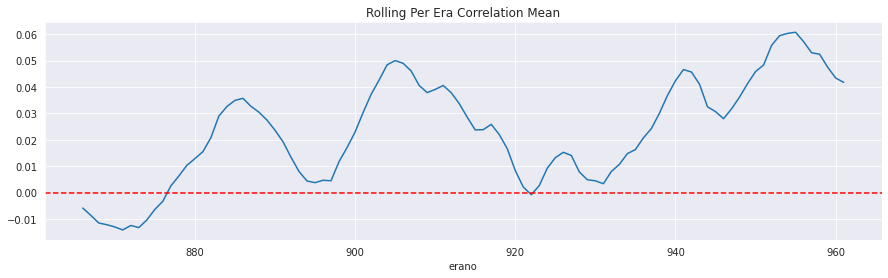

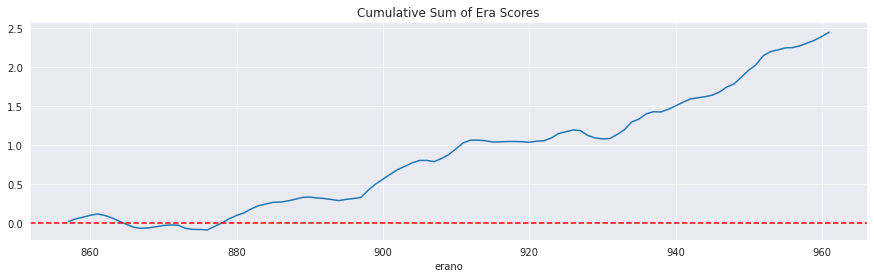

In [13]:
# Evaluate Validation Data
valid_df['prediction'] = lgb.predict(valid_df[features])

# Check distribution of predictions
print(valid_df['prediction'].describe().round(3))
print()
sns.histplot(valid_df['prediction'], bins=120)
plt.show()
print()

print("Validation Correlation Score:", correlation_score(valid_df['target'], valid_df['prediction']))
print()
mean_valid_era_scores = valid_df.groupby(valid_df['erano']).apply(score)
run_analytics(mean_valid_era_scores)

* Even though the model clearly overfits the training data, we do get decent performance on the validation data
* We get a decent avg corr of 0.0233 with 76.19% positive eras
* The standard deviation of 0.0344 is quite high 
* The Sharpe of 0.6973 is okay but could use some improvement

### Tournament Data
* Serve live predictions and submit through Numerai API
* Submissions must be in the form ['id', 'prediction']

In [14]:
# Download and Load Tournament data
napi.download_dataset('numerai_tournament_data_int8.parquet', 'numerai_tournament_data_int8.parquet')
tourney_df = pd.read_parquet('numerai_tournament_data_int8.parquet')
tourney_ids = tourney_df.index
print()
print("Tournament Data Shape: ", tourney_df.shape)
tourney_df.head()

2021-09-21 18:26:29,808 INFO numerapi.utils: starting download
numerai_tournament_data_int8.parquet: 582MB [00:29, 20.0MB/s]                           



Tournament Data Shape:  (1412925, 1073)


,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,...,feature_oscillating_elaborated_mandatory,feature_contradictory_museful_somatotropin,feature_direst_interrupted_paloma,feature_congenerical_anodal_chelation,feature_pronominal_rampant_megaspore,feature_dropsical_suctorial_mnemosyne,feature_corrugated_dotiest_committeewoman,feature_architectonic_godlier_southland,feature_fishiest_simulatory_roadholding,feature_unpruned_pedagoguish_inkblot,feature_forworn_hask_haet,feature_drawable_exhortative_dispersant,feature_metabolic_minded_armorist,feature_investigatory_inerasable_circumvallation,feature_centroclinal_incentive_lancelet,feature_unemotional_quietistic_chirper,feature_behaviorist_microbiological_farina,feature_lofty_acceptable_challenge,feature_coactive_prefatorial_lucy,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,target_alan_60,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,test,2,0,4,0,3,0,4,1,0,1,0,1,0,0,1,0,0,4,4,4,1,0,4,4,0,1,2,4,4,0,1,0,2,0,0,0,1,4,...,2,4,4,2,0,0,4,4,4,4,4,2,2,2,0,1,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n001e1318d5072ac,0575,test,1,4,2,2,1,3,3,0,3,2,4,2,4,4,3,4,3,2,1,1,4,1,0,1,2,1,0,1,1,3,1,4,3,4,4,4,4,2,...,2,1,3,3,3,0,2,2,0,0,0,3,3,4,2,3,4,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002a9c5ab785cbb,0575,test,1,2,2,3,1,1,3,0,1,1,2,3,4,4,2,4,2,3,1,2,2,1,2,2,3,1,1,1,1,3,3,4,1,2,3,4,2,1,...,3,2,3,0,0,0,4,4,0,0,0,0,3,1,1,1,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n002ccf6d0e8c5ad,0575,test,2,4,2,4,2,4,3,2,2,1,3,1,4,4,4,4,4,0,2,2,0,0,0,0,4,2,2,1,1,3,4,1,0,3,2,3,3,0,...,3,1,0,0,1,1,2,3,0,0,0,4,4,1,1,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n0051ab821295c29,0575,test,2,0,0,1,0,4,2,1,3,4,1,2,1,3,2,2,2,0,2,4,2,2,1,3,1,1,2,2,2,2,2,2,2,1,1,2,2,2,...,2,0,0,4,4,2,0,1,2,4,4,3,4,2,1,4,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
lgb = lightgbm.Booster(model_file='lgb_example.txt') # Load model if already trained and saved

# Generate tournament predictions (THIS MIGHT EXCEED VRAM THRESHOLD AND CRASH NOTEBOOK)
# tourney_df['prediction'] = lgb.predict(tourney_df[features]) 

# Alternatively, we can split the tournament dataset to save VRAM and concatenate at the end
tourney_preds_1 = lgb.predict(tourney_df[features][:500000])
tourney_preds_2 = lgb.predict(tourney_df[features][500000:1000000])
tourney_preds_3 = lgb.predict(tourney_df[features][1000000:])
tourney_df['prediction'] = np.concatenate((tourney_preds_1, tourney_preds_2, tourney_preds_3))

count    1412925.000
mean           0.500
std            0.014
min            0.366
25%            0.491
50%            0.500
75%            0.509
max            0.577
Name: prediction, dtype: float64



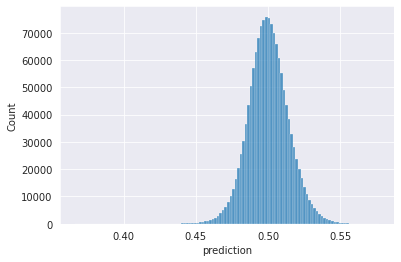

In [16]:
# Check distribution of predictions
print(tourney_df['prediction'].describe().round(3))
print()
sns.histplot(tourney_df['prediction'], bins=120)
plt.show()

In [17]:
# Instantiate Numerai API again but with API keys for submission
PUBLIC_KEY = 'ADD-PUBLIC-KEY-HERE'
PRIVATE_KEY = 'ADD-PRIVATE-KEY-HERE'

napi = NumerAPI(PUBLIC_KEY, PRIVATE_KEY)
current_round = napi.get_current_round()
print("ROUND NUMBER: ", current_round)

ROUND NUMBER:  282


In [18]:
# Format prediction CSV for submission
prediction_df = tourney_df.reset_index()[['id', 'prediction']]
prediction_df[['id', 'prediction']].to_csv(f'round{current_round}_example_model_predictions.csv', index=False) # Important to name your CSV file so you know which round and what model is used

In [19]:
# Submit CSV to Numerai 
# IMPORTANT TO SPECIFY version=2 TO SUBMIT TOURNAMENT PREDICTIONS FOR THE NEW DATASET
# USE version=1 IF SUBMITTING TOURNAMENT PREDICTIONS USING THE OLD DATASET

model_id = 'ADD-MODEL-ID-HERE'
napi.upload_predictions(f'round{current_round}_example_model_predictions.csv', model_id=model_id, version=2)

2021-09-21 18:28:35,514 INFO numerapi.base_api: uploading predictions...
2021-09-21 18:28:36,201 ERROR numerapi.base_api: Your session is invalid or has expired.


ValueError: ignored